## Project: Chest Xray based Disease Classificaton ##

###### By: Tushar Bansal, Aditya Sankhla, Aditya Dubey ######

About the dataset:

Int the dataset, each image has labels assigned to fourteen observations.
Eleven of these observations are pathologies. The remainder
observations indicate other findings in the report, or “no
finding”.
The eleven pathologies are as follows 
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Enlarged Cardiomediastinum
- Fracture (recent or healed)
- Lung Lesion
- Lung Opacity
- Pleural Effusion
- Pleural Other
- Pneumonia 
- Pneumothorax

Major Imports : tensorflow keras, pandas, numpy, matplotlib, sklearn

In [1]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
matplotlib.use("Agg") 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


Using TensorFlow backend.


#### Reading Data

In [ ]:
dtrain=pd.read_csv("CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)

### Data preprocessing




In [ ]:
dtrain[dtrain['No Finding'] == 1]['Sex'].value_counts()

Male       13111
Female      9269
Unknown        1
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Gender Distribution of the People with no diseases')

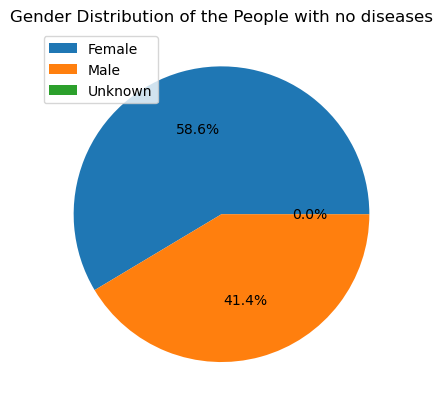

In [ ]:
plt.pie(dtrain[dtrain['No Finding'] == 1]['Sex'].value_counts(), autopct='%1.1f%%')
plt.legend(dtrain['Sex'].unique())
plt.title('Gender Distribution of the People with no diseases')

It is observed by the following chart that the dataset has a 60:40 ratio of females to males

In [ ]:
dtrain[dtrain['No Finding'] == 0]['Sex'].value_counts()

Series([], Name: Sex, dtype: int64)

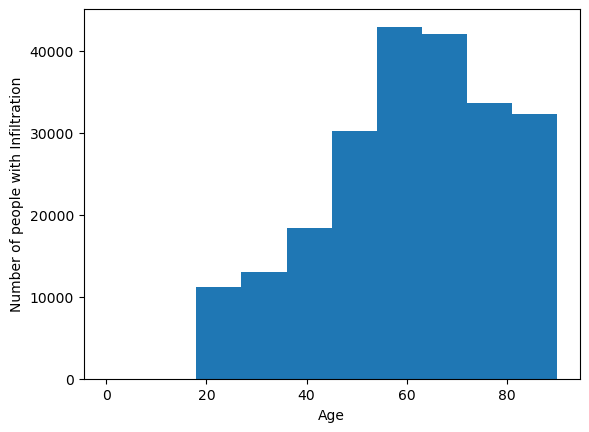

In [ ]:
dtrain['Age'].plot(kind='hist', bins=10)
plt.xlabel("Age")
plt.ylabel("Number of people with Infiltration")
plt.show()

The dataset seems to have a mixture of lateral and frontal images, lets focus solely on the frontal images to start with. 

Now, The features "Sex" , "Age", "Frontal/Lateral", "AP/PA" seems irrelevant for the main classification purpose so can be omitted. 

In [2]:
dnew=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

dtrain = dtrain.append(dnew)


dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]

dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)


In the dataset all the uncertainities are marked as -1.
Considering the dataset is medically important we should have main focus on minimizing the false negatives, therefore even in case of uncertaininity we should consider the result as positive.

Therefore, replacing all -1 values with 1.


In [3]:
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()
print(list(dtrain.columns))

print(list(dtrain.columns[1:15]))

['Path', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


#  Further Data Analysis 

Firstly, lets look at the number of positives in the datasets for all the present issues.

In [4]:
features_size=[]
features_data =[]
features_name=[]

for feature in list(dtrain.columns[1:15]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)
    
print(dtrain.shape)
print(list(dtrain.columns[1:15]))

print(features_size)
print(np.array(features_size)/dtrain.shape[0]*100)

(191229, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
[17000, 19578, 30158, 98759, 8149, 61535, 37396, 20664, 59658, 20408, 86541, 4318, 7935, 108184]
[ 8.88986503 10.23798692 15.77062056 51.64436356  4.26138295 32.17869675
 19.55561134 10.80589241 31.19715106 10.6720215  45.25516527  2.25802572
  4.14947524 56.57300932]


#### Visualising the dataset

In [ ]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os

Lets have a look at the first five images of the dataset to visualize what we are working with.

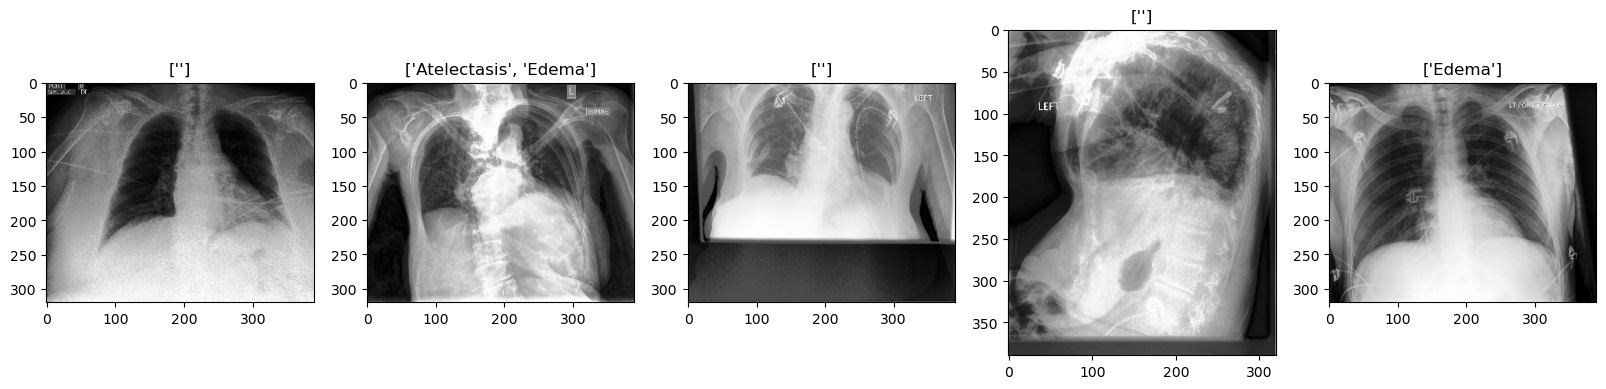

In [ ]:
paths =  dtrain.Path[:5]
labels = dtrain.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(cv2.imread(os.path.join('/kaggle/input/chexpertv10small/',paths[ii])))
    c_ax.set_title(labels[ii])

Viewing the first 10 images with more clarity using viridis cmap

In [ ]:


def show_image_heatmap(img_path, label):
    f = plt.figure(figsize=(12, 6))
    
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title(label)
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (128, 128))
    plt.imshow(resized_img, cmap='gray')
    plt.axis('off')

    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Heatmap')
    sns.heatmap(img[:, :, 0], cmap='viridis', cbar=False)
    plt.axis('off')

    plt.show()


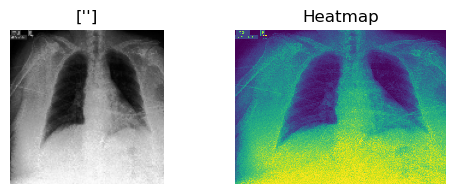

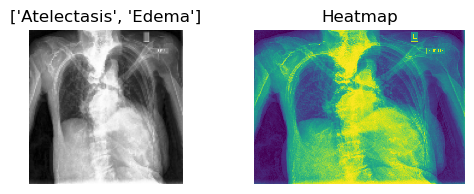

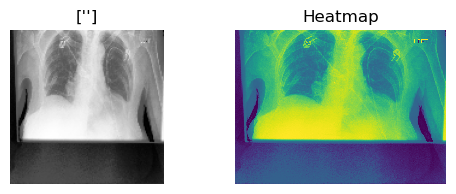

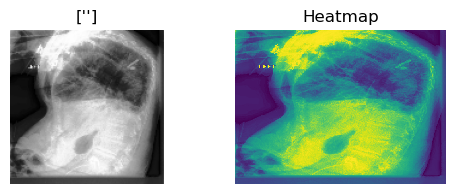

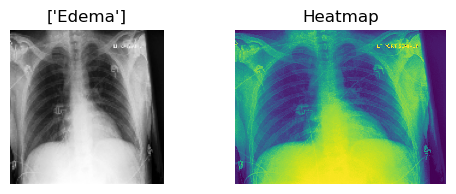

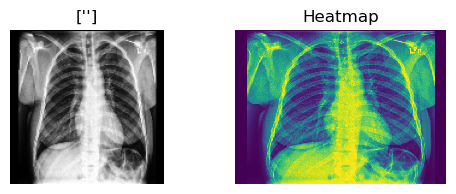

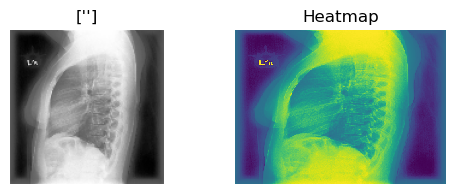

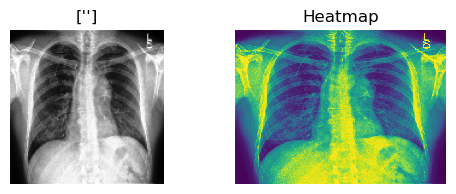

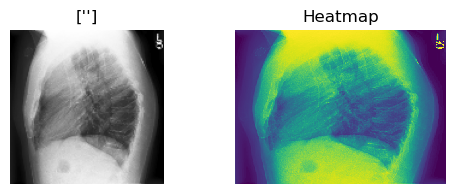

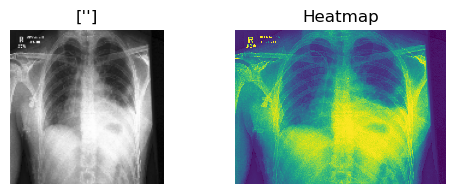

In [ ]:
labels = dtrain.feature_string[:10]

for i in range(10):
    img_path = '/kaggle/input/chexpertv10small/' + dtrain['Path'][i]
    label = labels[i]
    show_image_heatmap(img_path , label)

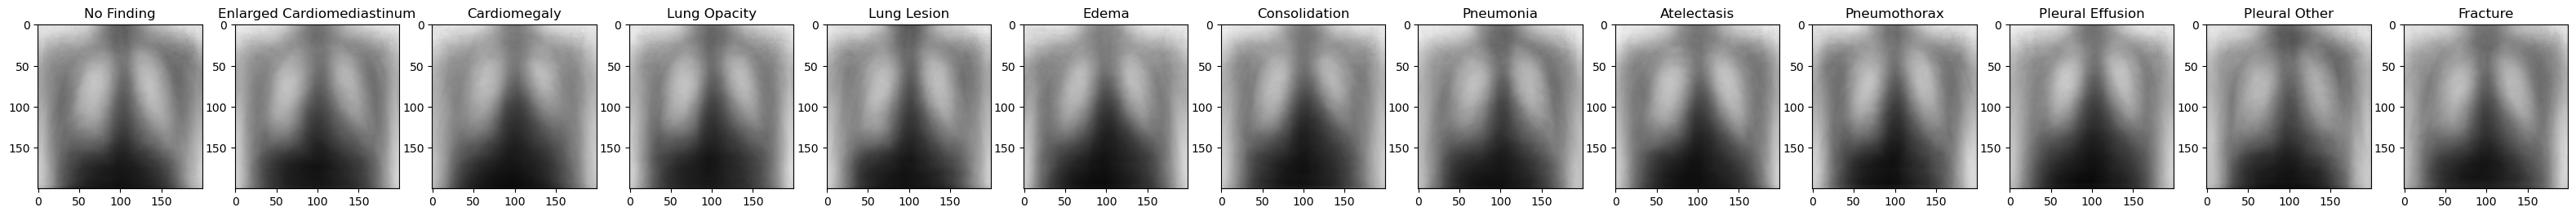

In [ ]:
classes = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity','Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
prototypes = []
for c in classes :
    base = np.zeros((200, 200, 3))
    images = dtrain[dtrain[c] == 1.0]['Path'].sample(100, random_state=69).tolist()
    for i in images : 
        nd_obj = cv2.resize(cv2.imread(os.path.join('/kaggle/input/chexpertv10small/',i)), (200,200))
        base += nd_obj
    base = base//len(images)
    base = (base * 255).astype(np.uint8)


    prototypes.append(base)
    
fig, m_axs = plt.subplots(1, len(prototypes), figsize = (40, 10))
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(prototypes[ii],cmap='gray')
    c_ax.set_title(classes[ii])

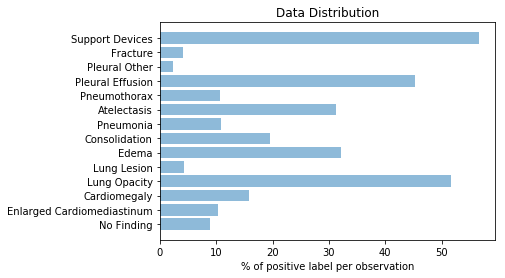

<Figure size 432x288 with 0 Axes>

In [5]:
%matplotlib inline
objects = list(dtrain.columns[1:15])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')


The results indicate the unbalanced data issue for different observations. As observed, the number of training data for Fracture, Pleural Other, and Lung Leison observations are very low comparing to for example the ones for Lung Opacity, Pleural Effusion or Support Device. Lets look at the correlation between observations to see if we can upsample the data for the observations with low training data. 

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


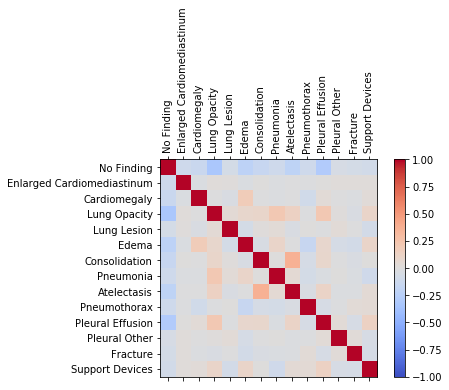

<Figure size 432x288 with 0 Axes>

In [6]:

data = dtrain[list(dtrain.columns[1:15])]
print(list(dtrain.columns[1:15]))
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()
plt.savefig('Correlation.png', bbox_inches='tight')


The correlation matrix displays though there are overlaps between some classes but no two features seems to be significantly related.

This low correlation between Lung Leision, Fracture and Pleural Other (3 of classes with low data) with the other classes particularly the ones with high data such as Lung Opacity would enable us to upsample these observations to balance the data further. Although there are also other approaches to deal with unbalanced data such as weighted loss, the upsampling method has similar impact without changing the model structure or loss function. This approach is implemented here. 

In [7]:
dtrain_upsample=[]
dtrain_upsample_list=[]

dtrain_upsample_list = [features_data[0],features_data[0],features_data[0],features_data[0],
                       features_data[1],
                       features_data[2],
                       features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
                       features_data[5],
                       features_data[6],
                       features_data[7],
                       features_data[8],
                       features_data[9],
                       features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
                       features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12]]

dtrain_upsample = pd.concat(dtrain_upsample_list) 
print(dtrain_upsample.shape)
print(list(dtrain_upsample.columns[1:15]))

(497398, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


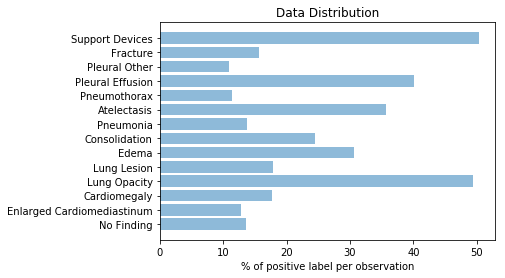

<Figure size 432x288 with 0 Axes>

In [8]:
features_sizeR=[]
features_dataR =[]
features_nameR=[]

for featureR in list(dtrain_upsample.columns[1:15]):
    data_featureR = dtrain_upsample.loc[dtrain_upsample[featureR] == 1]
    features_sizeR.append(data_featureR.shape[0])
    features_dataR.append(data_featureR)
    features_nameR.append(featureR)

objectsR = list(dtrain_upsample.columns[1:15])
y_posR = np.arange(len(objectsR))
performanceR = np.array(features_sizeR)/dtrain_upsample.shape[0]*100

plt.barh(y_posR, performanceR, align='center', alpha=0.5)
plt.yticks(y_posR, objectsR)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute_balanced.png', bbox_inches='tight')

After upsampling we have significant data for all classes.

([<matplotlib.axis.XTick at 0x7eaf0f54ef98>,
 <a list of 6 Text xticklabel objects>)

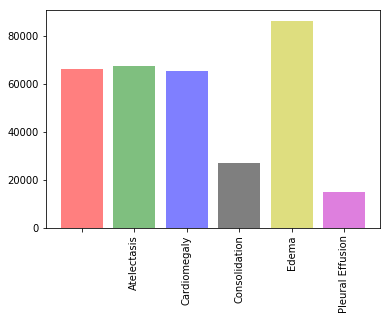

In [ ]:
from collections import Counter

labels_count = Counter(label for chexpert_targets in dtrain['feature_string'] for label in chexpert_targets)

x_pos = np.arange(len(labels_count.values()))

my_colors = 'rgbkymc'
chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
lbls = list.copy(chexpert_targets)
lbls.insert(0,'')
plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=my_colors)
plt.xticks(x_pos, lbls, rotation='vertical')


As it is observed above, the balance between observation is improved with this upsampling approach. However this increases the train data size and makes the training time slower. Now we split data to train/dev/test with 10% of data used for development and test

# Training Models

**Shuffling the data**: We shuffle the data to ensure that the training process is not biased by the order of the samples. This is done using the `sample(frac=1)` function, which randomly shuffles the entire dataset.

**Calculating the size of the validation and test sets**: We calculate the size of the validation and test sets to be 10% of the total dataset size each. This is done using the `round(0.1*dtrain_upsample.shape[0])` function.

**Splitting the data into training, validation, and test sets**: We split the shuffled dataset into training, validation, and test sets. The training set dtr consists of all samples except the last dvalid_size + dtest_size samples. The validation set dv consists of the next dvalid_size samples, and the test set dte consists of the remaining dvalid_size samples.

In [ ]:
dtrain_upsample = dtrain_upsample.sample(frac=1)

dvalid_size = round(0.1*dtrain_upsample.shape[0])

dtest_size = dvalid_size
dtr = dtrain_upsample[0:dtrain_upsample.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size-dtest_size:dtrain_upsample.shape[0]-dvalid_size+1]
dte = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size:dtrain_upsample.shape[0]+1]


In [ ]:
print(dtr.shape)
# dtr.describe().transpose()

(397919, 15)


In [ ]:
print(dv.shape)
#dv.describe().transpose()

(49741, 15)


In [ ]:
print(dte.shape)
#dte.describe().transpose()

(49740, 15)


# Data augmentation 

 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

- **Defining the target image size**: We define the target size for the images to be (224, 224). This is the size that the images will be resized to after they are read from disk.

- **Creating a data generator for the training data**: We create an ImageDataGenerator for the training data. This generator applies a series of random transformations to each image in the batch, including rotation, width and height shifts, shear transformation, zooming, and flipping. The `rescale=1./255` argument rescales the pixel values in the images from the range [0, 255] to the range [0, 1].

- **Creating a data generator for the validation and test data**: We create ImageDataGenerators for the validation and test data. These generators only rescale the pixel values in the images, but do not apply any other transformations. This is because we want to evaluate the model on the original validation/test data, not augmented data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=dtr,
    directory=None,
    x_col="Path",
    y_col=list(dtr.columns[1:15]),
    class_mode="other",
    drop_duplicates=False,
    target_size=target_size,
    batch_size=32  
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=dv,
    directory=None,
    x_col="Path",
    y_col=list(dv.columns[1:15]),
    class_mode="other",
    drop_duplicates=False,
    target_size=target_size,
    batch_size=32 
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=dte,
    directory=None,
    x_col="Path",
    y_col=list(dte.columns[1:15]),
    class_mode="other",
    drop_duplicates=False,
    target_size=target_size,
    shuffle=False,
    batch_size=1  


Found 397919 validated image filenames.
Found 49741 validated image filenames.
Found 49740 validated image filenames.


# Inception

**Inception architecture**, also known as **GoogLeNet**, is a type of Convolutional Neural Network (CNN) designed by researchers at Google. The key idea behind the Inception architecture is the use of **"Inception modules"** that allow the network to make more efficient use of computational resources.

An **Inception module** is a building block of the Inception architecture that includes several parallel convolutional layers with different kernel sizes (1x1, 3x3, 5x5) and a max-pooling layer. The outputs of these layers are then concatenated and sent to the next stage of the network. This design allows the network to learn a variety of features at each layer and increases the depth and width of the network without a significant increase in computational cost.


We create and train a model using the InceptionV3 architecture for a multi-label classification problem.

1. **Importing necessary modules**: The necessary modules for the InceptionV3 model and its preprocessing function are imported.

2. **Creating the base pre-trained model**: An instance of the InceptionV3 model with pre-trained weights from ImageNet is created.

3. **Modifying the preprocessing function for InceptionV3**: A new preprocessing function is defined that applies the preprocessing required for InceptionV3.

4. **Adding a global spatial average pooling layer and a fully-connected layer**: A global spatial average pooling layer is added to the output of the base model, followed by a fully-connected layer and a logistic layer.

5. **Creating the model**: A new model is created that includes the layers of the base model and the newly added layers.

6. **Freezing the layers of the base model**: The layers of the base model are frozen, meaning that their weights will not be updated during training.

7. **Compiling the model**: The model is compiled using the Adam optimizer, binary cross-entropy as the loss function, and accuracy as the metric.

8. **Training the model**: The model is trained using the fit_generator method, which allows the use of data generators for training.

9. **Saving the model**: The trained model is saved to a file so that it can be loaded later for inference.

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

base_model = InceptionV3(include_top=False, weights='imagenet')

def preprocess_input_inception(x):
    x = preprocess_input(x)
    return x

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

model_F = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

print(model_F.summary())

num_epochs = 3
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEP_SIZE_VALID,
                               epochs=num_epochs)

model_F.save("model_InceptionV3_Full.h5")


87910968/87910968 [==============================] - 0s 0us/step
Found 305645 validated image filenames.
Found 38206 validated image filenames.
Found 38205 validated image filenames.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_n

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2d_19 (Conv2D)             (None, None, None,   18432       ['mixed1[0][0]']                 
                                64)                                                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, None, None,   76800       ['activation_20[0][0]']          
                                64)                                                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, None, None,   82944       ['activation_23[0][0]']          
                                96)                                                               
                                                                                                  
 conv2d_25

/tmp/ipykernel_32/3461981220.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_H = model_F.fit_generator(generator=train_generator,


Epoch 1/3
9551/9551 [==============================] - 1879s 196ms/step - loss: 0.3927 - accuracy: 0.1394 - val_loss: 0.3872 - val_accuracy: 0.1612
Epoch 2/3
9551/9551 [==============================] - 2086s 218ms/step - loss: 0.3842 - accuracy: 0.1419 - val_loss: 0.3833 - val_accuracy: 0.1232
Epoch 3/3
9551/9551 [==============================] - 1976s 207ms/step - loss: 0.3806 - accuracy: 0.1439 - val_loss: 0.3840 - val_accuracy: 0.0924


We perform the following operations:

1. **Loading the model**: The previously saved model 'model_InceptionV3_Full.h5' is loaded into 'model_F'.

2. **Setting the number of epochs**: The number of epochs for the training process is set to 5.

3. **Calculating the step size for training, validation, and testing**: The step size for each of these sets is calculated by dividing the total number of samples in each set by the batch size. This determines the total number of steps it would take to pass through the entire dataset once (i.e., one epoch) given the batch size.

In [ ]:
model_F = load_model('model_InceptionV3_Full.h5')
num_epochs = 5
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

1. **Resetting the test generator**: The `reset()` function is called on the test generator to ensure the generator is at the beginning of the test set.

2. **Making predictions**: The `predict_generator()` function is used on the model to make predictions on the data yielded batch-by-batch by the test generator.

3. **Thresholding the predictions**: The predictions are thresholded at 0.5, meaning that predicted probabilities greater than or equal to 0.5 are considered as positive classes (1), and those less than 0.5 as negative classes (0).

4. **Converting predictions to integer type**: The thresholded predictions are converted to integer type.

5. **Extracting the true labels**: The true labels for the test data are extracted from the test dataframe.

6. **Printing the classification report**: The `classification_report()` function from sklearn.metrics is used to calculate and display the precision, recall, F1-score, and support for each class.

In [ ]:
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

/tmp/ipykernel_32/2749914481.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)


                            precision    recall  f1-score   support

                No Finding       0.52      0.22      0.31      3387
Enlarged Cardiomediastinum       0.00      0.00      0.00      3876
              Cardiomegaly       0.51      0.12      0.20      6128
              Lung Opacity       0.66      0.52      0.58     19694
               Lung Lesion       0.00      0.00      0.00      1643
                     Edema       0.62      0.45      0.52     12052
             Consolidation       0.00      0.00      0.00      7384
                 Pneumonia       0.40      0.00      0.00      4168
               Atelectasis       0.55      0.05      0.08     11957
              Pneumothorax       0.57      0.04      0.08      4064
          Pleural Effusion       0.71      0.56      0.63     17195
             Pleural Other       0.00      0.00      0.00       835
                  Fracture       0.00      0.00      0.00      1542
           Support Devices       0.70      0.86

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/tmp/ipykernel_32/3935725377.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)


Test score: 0.3829108476638794
Test accuracy: 0.0921083614230156


As we can see the accuracy and score are very low using this model. We shall now explore a couple more models.

# ResNet

**ResNet50** is a 50-layer deep convolutional neural network (CNN) architecture. It uses "skip connections" to combat the vanishing gradient problem, allowing it to effectively learn complex patterns. 

We create and train a model using the ResNet50 architecture for a multi-label classification problem.

1. **Creating the base pre-trained model**: An instance of the ResNet50 model with pre-trained weights from ImageNet is created.

2. **Adding a global spatial average pooling layer and a fully-connected layer**: A global spatial average pooling layer is added to the output of the base model, followed by a fully-connected layer and a logistic layer.

3. **Creating the model**: A new model is created that includes the layers of the base model and the newly added layers.

4. **Compiling the model**: The model is compiled using the Adam optimizer, binary cross-entropy as the loss function, and accuracy as the metric.

In [ ]:
base_model = ResNet50(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

model_F = Model(inputs=base_model.input, outputs=predictions)

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

print(model_F.summary())

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                             

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv3_block4_out (Activation)  (None, None, None,   0           ['conv3_block4_add[0][0]']       
                                512)                                                              
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, None, None,   131328      ['conv3_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

1. **Setting the number of epochs**: The number of epochs for the training process is set to 3.

2. **Calculating the step size for training, validation, and testing**: The step size for each of these sets is calculated by dividing the total number of samples in each set by the batch size. This determines the total number of steps it would take to pass through the entire dataset once (i.e., one epoch) given the batch size.

3. **Training the model**: The model is trained using the `fit_generator` method, which allows us to use data generators for training. We specify the training data generator, the number of steps per epoch, the validation data generator, the number of validation steps, and the number of epochs.

4. **Saving the model**: Finally, the trained model is saved to a file so that it can be loaded later for inference.

In [ ]:
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)

model_F.save("model_ResNet50_Full.h5")

/tmp/ipykernel_32/3440258717.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_H = model_F.fit_generator(generator=train_generator,


Epoch 1/3
9551/9551 [==============================] - 1937s 201ms/step - loss: 0.3486 - accuracy: 0.1698 - val_loss: 0.3426 - val_accuracy: 0.1706
Epoch 2/3
9551/9551 [==============================] - 1811s 190ms/step - loss: 0.3142 - accuracy: 0.1890 - val_loss: 0.3219 - val_accuracy: 0.1834
Epoch 3/3
9551/9551 [==============================] - 1814s 190ms/step - loss: 0.2584 - accuracy: 0.2324 - val_loss: 0.3074 - val_accuracy: 0.1908


# DenseNet 121 Architecture

DenseNet121 is a 121-layer deep convolutional neural network known for its “dense connections”, where each layer is connected to every other layer in a feed-forward fashion.

In [ ]:
base_model = DenseNet121(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

model_F = Model(inputs=base_model.input, outputs=predictions)

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

print(model_F.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, None, None,   0          ['input_2[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_2[0][0]']       
                                64)                                                         

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block5_2_conv (Conv2D)   (None, None, None,   36864       ['conv3_block5_1_relu[0][0]']    
          

In [ ]:
num_epochs = 5
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)

model_F.save("model_DenseNet121_Full_Sample.h5")

/tmp/ipykernel_32/4264485105.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_H = model_F.fit_generator(generator=train_generator,


Epoch 1/5
12434/12434 [==============================] - 2459s 197ms/step - loss: 0.3692 - accuracy: 0.1867 - val_loss: 0.3110 - val_accuracy: 0.2217
Epoch 2/5
12434/12434 [==============================] - 2426s 195ms/step - loss: 0.2513 - accuracy: 0.2343 - val_loss: 0.2492 - val_accuracy: 0.2596
Epoch 3/5
12434/12434 [==============================] - 2421s 195ms/step - loss: 0.1938 - accuracy: 0.2707 - val_loss: 0.2348 - val_accuracy: 0.2727
Epoch 4/5
12434/12434 [==============================] - 2435s 196ms/step - loss: 0.1651 - accuracy: 0.2929 - val_loss: 0.2370 - val_accuracy: 0.3341
Epoch 5/5
12434/12434 [==============================] - 2441s 196ms/step - loss: 0.1443 - accuracy: 0.3075 - val_loss: 0.2125 - val_accuracy: 0.2694


In [ ]:
model_F = load_model('model_DenseNet121_Full_Sample.h5')
num_epochs = 5
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

1. **Resetting the test generator**: The `reset()` function is called on the test generator to ensure the generator is at the beginning of the test set.

2. **Making predictions**: The `predict_generator()` function is used on the model to make predictions on the data yielded batch-by-batch by the test generator.

3. **Thresholding the predictions**: The predictions are thresholded at 0.5, meaning that predicted probabilities greater than or equal to 0.5 are considered as positive classes (1), and those less than 0.5 as negative classes (0).

4. **Converting predictions to integer type**: The thresholded predictions are converted to integer type.

5. **Extracting the true labels**: The true labels for the test data are extracted from the test dataframe.

6. **Printing the classification report**: The `classification_report()` function from sklearn.metrics is used to calculate and display the precision, recall, F1-score, and support for each class.

In [ ]:
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

/tmp/ipykernel_32/2749914481.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)


                            precision    recall  f1-score   support

                No Finding       0.90      0.89      0.89      6903
Enlarged Cardiomediastinum       0.68      0.69      0.69      6456
              Cardiomegaly       0.84      0.73      0.78      8741
              Lung Opacity       0.86      0.80      0.83     24517
               Lung Lesion       0.93      0.97      0.95      8806
                     Edema       0.91      0.59      0.71     15229
             Consolidation       0.66      0.86      0.75     12202
                 Pneumonia       0.89      0.55      0.68      6855
               Atelectasis       0.74      0.91      0.81     17793
              Pneumothorax       0.79      0.76      0.78      5654
          Pleural Effusion       0.86      0.89      0.87     20018
             Pleural Other       0.94      0.99      0.96      5451
                  Fracture       0.85      0.99      0.92      7729
           Support Devices       0.91      0.89

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/tmp/ipykernel_32/3935725377.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)


Test score: 0.21193811297416687
Test accuracy: 0.2705066204071045


As we can see, we are getting 27% accuracy using this model. This is still not too good but better than the models so far. So we shall focus here and finetune it further in the hopes of increasing this accuracy.

# Densenet with learning rate scheduler and fine tuning

A learning rate scheduler adjusts the learning rate during training. It can help the model converge faster and achieve better performance.

Fine-tuning involves slightly adjusting the weights of a pre-trained model to adapt it to a new task. 

The code below is almost the same as before except a few changes. Firstly, we have made the last 50 layers trainable now in order to fine tune it. Apart from this we have also introduced a learning rate scheduling function.

In [ ]:
from keras.callbacks import LearningRateScheduler
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import keras

base_model = DenseNet121(include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(14, activation='sigmoid')(x)

model_F = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:-50]:  
    layer.trainable = True

def lr_schedule(epoch):
    initial_lr = 0.0001  
    if epoch < 2:
        return initial_lr
    else:
        return initial_lr * 0.1  
    
lr_scheduler = LearningRateScheduler(lr_schedule)

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

print(model_F.summary())
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

num_epochs = 4  
model_H = model_F.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=num_epochs,
    callbacks=[lr_scheduler]  

model_F.save("model_DenseNet121_Full_Sample_FineTuned.h5")


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                             

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv3_block3_0_relu (Activatio  (None, None, None,   0          ['conv3_block3_0_bn[0][0]']      
 n)                             192)                                                              
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, None, None,   24576       ['conv3_block3_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block3_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

/tmp/ipykernel_32/169667680.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_H = model_F.fit_generator(


Epoch 1/4
12434/12434 [==============================] - 7319s 587ms/step - loss: 0.4228 - accuracy: 0.1758 - val_loss: 0.4603 - val_accuracy: 0.2648 - lr: 1.0000e-04
Epoch 2/4
12434/12434 [==============================] - 5842s 470ms/step - loss: 0.3980 - accuracy: 0.1811 - val_loss: 0.4305 - val_accuracy: 0.1533 - lr: 1.0000e-04
Epoch 3/4
12434/12434 [==============================] - 5707s 459ms/step - loss: 0.3756 - accuracy: 0.1864 - val_loss: 0.4076 - val_accuracy: 0.2182 - lr: 1.0000e-05
Epoch 4/4
12434/12434 [==============================] - 5834s 469ms/step - loss: 0.3681 - accuracy: 0.1888 - val_loss: 0.4272 - val_accuracy: 0.2475 - lr: 1.0000e-05


In [ ]:
model_F = load_model('model_DenseNet121_Full_Sample_FineTuned.h5')
num_epochs = 5
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

/tmp/ipykernel_32/2749914481.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)


                            precision    recall  f1-score   support

                No Finding       0.60      0.47      0.53      6808
Enlarged Cardiomediastinum       0.71      0.01      0.02      6368
              Cardiomegaly       0.75      0.21      0.33      8831
              Lung Opacity       0.63      0.82      0.71     24254
               Lung Lesion       0.78      0.25      0.38      8935
                     Edema       0.62      0.80      0.70     15267
             Consolidation       0.53      0.10      0.17     12168
                 Pneumonia       0.54      0.13      0.21      6714
               Atelectasis       0.60      0.52      0.56     17469
              Pneumothorax       0.56      0.36      0.44      5658
          Pleural Effusion       0.81      0.58      0.67     19738
             Pleural Other       0.68      0.14      0.23      5461
                  Fracture       0.80      0.15      0.25      7974
           Support Devices       0.84      0.62

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/tmp/ipykernel_32/3935725377.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)


Test score: 0.4264622926712036
Test accuracy: 0.24189786612987518


# Densenet with pretrained weights and fine tuning

In [ ]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

1. **Base Model**: DenseNet121 is used as the base model. The model is initialized with weights pre-trained on ImageNet.

2. **Additional Layers**: After the base model, several layers are added including a GlobalAveragePooling2D layer, two dense layers with ReLU activation, Batch Normalization, Dropout, and a final dense layer with sigmoid activation for multi-label classification.

3. **Loading Previous Weights**: If `load_previous_weights` is set to True, the function attempts to load weights from a previous training session.

4. **Freezing Layers**: If `freeze_cnn` is set to True, all layers in the base model are frozen, meaning their weights will not be updated during training. Otherwise, only the last 20 layers of the base model are set to be trainable.

5. **Model Compilation**: The model is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy and AUC as metrics.

The function returns the constructed model.

In [ ]:
def build_model(image_size = 224, load_previous_weights = True, freeze_cnn = False):
    base_model = DenseNet121(include_top= False, input_shape=(image_size,image_size,3), weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D(input_shape=(1024,1,1))(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(14, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)

    if load_previous_weights:
        try:
            model.load_weights('../input/chexpert-keras-base/weights.hdf5')
            print('Weights successfuly loaded')
        except:
            print('Weights not loaded')

    if freeze_cnn:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers[-20:]: 
            layer.trainable = True
            
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', auc])
        
    return model

In [ ]:
def train_model(model , datasets, epochs=1, image_size = 224):
    
    checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                                   verbose=1, save_best_only=True)
    
    train_generator,validation_generator,test_generator = datasets
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    print(STEP_SIZE_TRAIN)
    print(STEP_SIZE_VALID)

    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, callbacks = [checkpointer])
    return history

In [ ]:
image_size_input = 224
model = build_model(image_size = image_size_input)

Weights successfuly loaded


In [ ]:
datasets = generate_datasets(image_size = image_size_input)
train_generator,validation_generator,test_generator = datasets

Found 201073 images belonging to 6 classes.
Found 22341 images belonging to 6 classes.
Found 234 images belonging to 6 classes.


In [ ]:
history = train_model(model , datasets, epochs=3, image_size = image_size_input)
history.history

6283
698
Epoch 1/3
6283/6283 [==============================] - 7923s 1s/step - loss: 2.0158 - acc: 0.4064 - auc: 0.8395 - val_loss: 1.9275 - val_acc: 0.4585 - val_auc: 0.8398

Epoch 00001: val_loss improved from inf to 1.92747, saving model to weights.hdf5
Epoch 2/3
6283/6283 [==============================] - 7201s 1s/step - loss: 2.0086 - acc: 0.4101 - auc: 0.8403 - val_loss: 1.9497 - val_acc: 0.4514 - val_auc: 0.8404

Epoch 00002: val_loss did not improve from 1.92747
Epoch 3/3
6283/6283 [==============================] - 7299s 1s/step - loss: 2.0000 - acc: 0.4134 - auc: 0.8407 - val_loss: 1.9746 - val_acc: 0.4179 - val_auc: 0.8410

Epoch 00003: val_loss did not improve from 1.92747


{'val_loss': [1.927469452848407, 1.9496782452443826, 1.9746132036118735],
 'val_acc': [0.4584527220630373, 0.45138733246805335, 0.41790308844097906],
 'val_auc': [0.8398154120902961, 0.8403681201725134, 0.8410030890384245],
 'loss': [2.0157785887515565, 2.00860957415955, 2.000034786283585],
 'acc': [0.40642408085309567, 0.41013524604641455, 0.4134181584855299],
 'auc': [0.8395005259167782, 0.8403208928777525, 0.8406996619744019]}

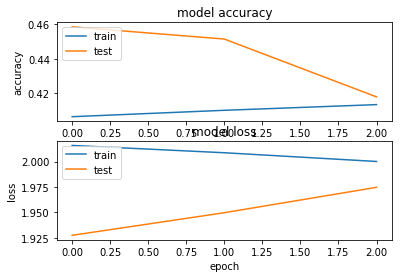

In [ ]:
plt.figure(1)    

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

1. **Plot Initialization**: A figure is created and the line of no-discrimination (from (0,0) to (1,1)) is plotted.

2. **ROC Curve Calculation and Plotting**: For each class, the True Positive Rate (TPR) and False Positive Rate (FPR) are calculated at various threshold settings, and the Area Under the Curve (AUC) is computed. The ROC curve is then plotted for each class.

3. **Plot Customization**: Labels for the x-axis, y-axis, and title are set. A legend is added to the plot.

4. **Displaying the Plot**: The plot is displayed using `plt.show()`. This will show the ROC curves of all classes, providing a measure of the model's performance across different classification thresholds. The AUC for each class gives a single metric to compare the model's performance across classes - the closer the AUC is to 1, the better the model is at distinguishing between positive and negative instances for that class. 

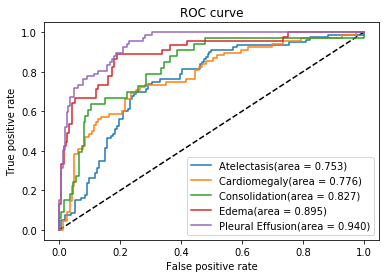

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

for ii in range(1, y_pred_keras.shape[1]):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels[:,ii], y_pred_keras[:,ii])
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label=chexpert_targets[ii-1] + '(area = {:.3f})'.format(auc_keras))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
    



# Heatmap to visualize output

Now that we have trained our model, we can use it to visualize the results

In [ ]:
x = test_generator[0][0]
preds = model.predict(x)

importing the last convulation layer of the model

In [ ]:
preds = y_pred[1,:]
class_idx = np.argmax(preds)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv5_block16_concat")

In [ ]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(1024):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

Heatmap generation

In [ ]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

Text(0.5, 1.0, 'Heat map')

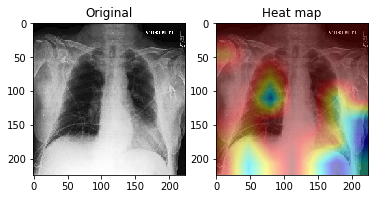

In [ ]:
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(superimposed_img)
plt.title("Heat map")

# Final model

From the above trials, DenseNet-121 seems to be the best. And is selected for CNN structure. A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify DenseNet-121 architecture for our application. The weights are initialized with a network weights tuned for imagenet data.

Alongside:
- loss function is defined as binary cross entropy loss. 
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None.

In [14]:
base_model = DenseNet121(include_top = False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(14, activation='sigmoid')(x)


# Final model
model_F = Model(inputs=base_model.input, outputs=predictions)


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_F.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

print(model_F.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________________

Fitting the model

In [15]:
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model_F.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)
# save model
model_F.save("model_DenseNet121_Full_Sample.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
12434/12434 [==============================] - 11426s 919ms/step - loss: 0.3691 - acc: 0.8346 - val_loss: 0.3093 - val_acc: 0.8635
Epoch 2/3
12434/12434 [==============================] - 11390s 916ms/step - loss: 0.2513 - acc: 0.8914 - val_loss: 0.2425 - val_acc: 0.8956
Epoch 3/3
12434/12434 [==============================] - 11384s 916ms/step - loss: 0.1944 - acc: 0.9167 - val_loss: 0.2201 - val_acc: 0.9064


load the trained model here.

In [15]:
model_F = load_model('model_DenseNet121_Full_Sample.h5')
num_epochs = 3
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Instructions for updating:
Use tf.cast instead.


Calculate precision, recall, and f1-score on test data. **The threshold for positive is set to 0.5**
As it can be seen in the table below, all performance indexes particularly F1 score are improved significantly. 

In [16]:
test_generator.reset()
pred=model_F.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.94      0.83      0.88      6834
Enlarged Cardiomediastinum       0.87      0.52      0.65      6299
              Cardiomegaly       0.75      0.81      0.78      8784
              Lung Opacity       0.84      0.83      0.83     24487
               Lung Lesion       0.96      0.94      0.95      8821
                     Edema       0.84      0.82      0.83     15215
             Consolidation       0.65      0.82      0.73     12342
                 Pneumonia       0.84      0.60      0.70      6918
               Atelectasis       0.85      0.71      0.77     17766
              Pneumothorax       0.90      0.68      0.77      5595
          Pleural Effusion       0.86      0.91      0.88     20046
             Pleural Other       0.93      0.98      0.95      5375
                  Fracture       0.89      0.98      0.93      7767
           Support Devices       0.90      0.91

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Calculating accuracy on test data

In [17]:
score, acc = model_F.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.18624548949727385
Test accuracy: 0.9206114595105095


Now let's calculate precision, recall, and F1 score on the original test set used for other models assessment. For this purpuse, we repeat the split of data before up-sampling to balance class labels. 

In [20]:

dvalid_size = round(0.1*dtrain.shape[0])
dtest_size = dvalid_size

dte_o = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]
print(dte_o.shape)

test_o_datagen=ImageDataGenerator(rescale=1./255.)
target_size = (224,224)
test_o_generator=test_o_datagen.flow_from_dataframe(dataframe=dte_o, directory=None, x_col="Path", y_col=list(dte_o.columns[1:15]), class_mode="other", target_size=target_size, shuffle = False, batch_size=1)
STEP_SIZE_TEST_O=test_o_generator.n//test_o_generator.batch_size


(19123, 15)
Found 19123 images.


Calculating precision, recall, and f1-score on original test data prior upsampling for balancing to compare with the other models on the same test set. It is seen that the F1 score results are significantly improved on the original test set. 

In [21]:
test_o_generator.reset()
pred=model_F.predict_generator(test_o_generator, steps=STEP_SIZE_TEST_O)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte_o.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

                            precision    recall  f1-score   support

                No Finding       0.72      0.84      0.77      2291
Enlarged Cardiomediastinum       0.63      0.32      0.42      2100
              Cardiomegaly       0.58      0.70      0.64      2662
              Lung Opacity       0.74      0.71      0.73      9283
               Lung Lesion       0.71      0.95      0.81       861
                     Edema       0.69      0.73      0.71      5619
             Consolidation       0.43      0.76      0.55      3643
                 Pneumonia       0.64      0.45      0.52      2042
               Atelectasis       0.66      0.65      0.66      6581
              Pneumothorax       0.64      0.51      0.57      1439
          Pleural Effusion       0.77      0.76      0.77      6775
             Pleural Other       0.59      0.96      0.73       314
                  Fracture       0.52      0.99      0.68       880
           Support Devices       0.85      0.83

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [37]:
indx=1000
print(y_pred[indx])
print(y_true[indx])

[0 0 0 1 0 1 0 1 1 0 0 0 1 0]
[0 0 0 1 0 1 0 1 1 0 0 0 1 0]


In [38]:
score, acc = model_F.evaluate_generator(test_o_generator, steps=STEP_SIZE_TEST_O)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.28497016770311495
Test accuracy: 0.8774997889995575


As observed, the *accuracy of the final model comes out to be 0.877*